In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import geoplot
import geopandas
import pycountry
from github import Github
from datetime import datetime
from functools import reduce

plt.rcParams["figure.figsize"] = (16, 10)

In [2]:
who_daily_reports_dir_name = "who_daily_reports"

# WHO daily reports data download

In [3]:
who_repo_name = "CSSEGISandData/COVID-19"
who_repo_daily_reports_dir_path = "csse_covid_19_data/csse_covid_19_daily_reports"

In [4]:
# github = Github("user", "password") # Using authenticated connection changes api limit from 60 per hour to 5000 per hour
github = Github()
repo = github.get_repo(who_repo_name)
reports_dir_content = repo.get_contents(who_repo_daily_reports_dir_path)
reports = list(filter(lambda report: ".csv" in report.name, reports_dir_content))
reports[:5]

[ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-22-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-23-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-24-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-25-2020.csv"),
 ContentFile(path="csse_covid_19_data/csse_covid_19_daily_reports/01-26-2020.csv")]

In [5]:
try:
    os.mkdir(who_daily_reports_dir_name)
    print("Created directory", who_daily_reports_dir_name)
except FileExistsError:
    print('WHO daily reports directory already exists')
    
new_files_paths = []
for report in reports:
    try:
        report_file_path = os.path.join(who_daily_reports_dir_name, report.name)
        report_file = open(report_file_path, 'x')
        report_file.write(report.decoded_content.decode('utf-8'))
        report_file.close()
        new_files_paths.append(report_file_path)
        print("Created report file", report_file_path)
    except FileExistsError:
        print("Daily report file", report_file_path, "already exists")
    except Exception as err:
        print("API rate limit exceeded, try again in an hour")
        print(err)
        report_file.close()
        os.remove(report_file_path)
        break

WHO daily reports directory already exists
Daily report file who_daily_reports/01-22-2020.csv already exists
Daily report file who_daily_reports/01-23-2020.csv already exists
Daily report file who_daily_reports/01-24-2020.csv already exists
Daily report file who_daily_reports/01-25-2020.csv already exists
Daily report file who_daily_reports/01-26-2020.csv already exists
Daily report file who_daily_reports/01-27-2020.csv already exists
Daily report file who_daily_reports/01-28-2020.csv already exists
Daily report file who_daily_reports/01-29-2020.csv already exists
Daily report file who_daily_reports/01-30-2020.csv already exists
Daily report file who_daily_reports/01-31-2020.csv already exists
Daily report file who_daily_reports/02-01-2020.csv already exists
Daily report file who_daily_reports/02-02-2020.csv already exists
Daily report file who_daily_reports/02-03-2020.csv already exists
Daily report file who_daily_reports/02-04-2020.csv already exists
Daily report file who_daily_repor

### Unify countries names in newly downloaded dataframe

In [6]:
unrecognizable_countries = ['Others', 'Diamond Princess', 'MS Zaandam', 'Cruise Ship']
countries_proper_names = {
    'Congo (Brazzaville)': 'Congo',
    'Congo (Kinshasa)': 'Congo',
    'Korea, South': 'Korea, Republic of',
    'South Korea': 'Korea, Republic of',
    'Laos': 'Lao People\'s Democratic Republic',
    'Taiwan*': 'Taiwan, Province of China',
    'Burma': 'Myanmar',
    'West Bank and Gaza': 'Palestine, State of',
    'occupied Palestinian territory': 'Palestine, State of',
    'Macau': 'Macao',
    'Mainland China': 'China',
    'Ivory Coast': 'Côte d\'Ivoire',
    'North Ireland': 'United Kingdom',
    'Republic of Ireland': 'Ireland',
    'Gambia, The': 'Gambia',
    'East Timor': 'Timor-Leste',
    'Cape Verde': 'Cabo Verde',
    'Bahamas, The': 'Bahamas',
    'Taipei and environs': 'Taiwan, Province of China',
    'Iran (Islamic Republic of)': 'Iran, Islamic Republic of',
    'St. Martin': 'France',
    'Channel Islands': 'United Kingdom',
}

In [7]:
for new_file_path in new_files_paths:
    df = pd.read_csv(new_file_path)
    
    if 'Country/Region' in df.columns:
        countries_column = 'Country/Region'
    elif 'Country_Region' in df.columns:
        countries_column = 'Country_Region'
    else:
        raise Exception("Not recognized countries column")
        
    df.replace({countries_column: countries_proper_names}, inplace=True)
    countries = df[countries_column]
    
    new_countries_names = []
    for country in countries:
        if country in unrecognizable_countries:
            new_countries_names.append(country)
        elif country == 'US':
            new_countries_names.append('United States')
        elif country == 'China':
            new_countries_names.append('China')
        elif country == 'United Kingdom':
            new_countries_names.append('United Kingdom')
        else:
            try:
                new_countries_names.append(pycountry.countries.search_fuzzy(country)[0].name)
            except:
                print('Unrecognized country name encounter: \'' + str(country) + '\' in report: ' + new_file_path)
                new_countries_names.append(country)
    
    df[countries_column] = new_countries_names
    df.to_csv(new_file_path, index=False)
    print('Unified countries names in report:', new_file_path)

Unified countries names in report: who_daily_reports/04-23-2020.csv
Unified countries names in report: who_daily_reports/04-24-2020.csv


# WHO daily reports parsing

In [8]:
column_names = ['Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']
new_column_names = ['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Recovered']

reports_files_names = sorted(os.listdir(who_daily_reports_dir_name))
reports = []
for report_file_name in reports_files_names:
    date = datetime.strptime(report_file_name[:-4], '%m-%d-%Y')
    dataframe = pd.read_csv(os.path.join(who_daily_reports_dir_name, report_file_name))
    
    try:
        dataframe = dataframe[column_names]
    except KeyError:
        dataframe = dataframe[new_column_names]
        dataframe = dataframe.rename(columns={'Province_State': 'Province/State', 'Country_Region': 'Country/Region'})
    
    dataframe['Province/State'].fillna("NotSpecified", inplace=True)
    dataframe.fillna(0, inplace=True)

    dataframe = dataframe.astype({'Confirmed': 'int32', 'Deaths': 'int32', 'Recovered': 'int32'}, copy=False)
    
    reports.append((date, dataframe))
    
reports = np.array(reports)

In [9]:
def print_unrecognized_countries(reports, countries_to_ignore, corrected_names_dict):
    '''
    Utility function that prints not recognized countries names in given reports

    Parameters
    ----------
    reports : list
        List of reports dataframes to test
    countries_to_ignore : list
        List of countries names that will be ignored
    corrected_names_dict : dict
        Dictionary containing mapping between unrecognizable countries names and proper countries names
    '''
    for date, report in reports:
        rep = report.copy().loc[:, ['Country/Region']]
        rep = rep.loc[~rep['Country/Region'].isin(countries_to_ignore), :]
        rep.replace({'Country/Region': corrected_names_dict}, inplace=True)
        rep = rep.groupby('Country/Region', as_index=False).sum()
        wrong_countries_count = 0
        for country in rep['Country/Region']:
            try:
                pycountry.countries.search_fuzzy(country)[0].name
            except:
                wrong_countries_count != 1
                print(country)
        if wrong_countries_count == 0:
            print('Finished checking report', date, 'no unrecognized countries names found')
        else:
            print('Finished checking report', date)
                
print_unrecognized_countries(reports[-1:], unrecognizable_countries, countries_proper_names)

Finished checking report 2020-04-24 00:00:00 no unrecognized countries names found


In [10]:
reports[:5, 0]

array([datetime.datetime(2020, 1, 22, 0, 0),
       datetime.datetime(2020, 1, 23, 0, 0),
       datetime.datetime(2020, 1, 24, 0, 0),
       datetime.datetime(2020, 1, 25, 0, 0),
       datetime.datetime(2020, 1, 26, 0, 0)], dtype=object)

In [11]:
reports[-1, 1].head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,South Carolina,United States,24,0,0
1,Louisiana,United States,129,7,0
2,Virginia,United States,100,3,0
3,Idaho,United States,642,14,0
4,Iowa,United States,1,0,0


In [12]:
reports[0, 1].dtypes

Province/State    object
Country/Region    object
Confirmed          int32
Deaths             int32
Recovered          int32
dtype: object

# Plotting COVID data for whole world

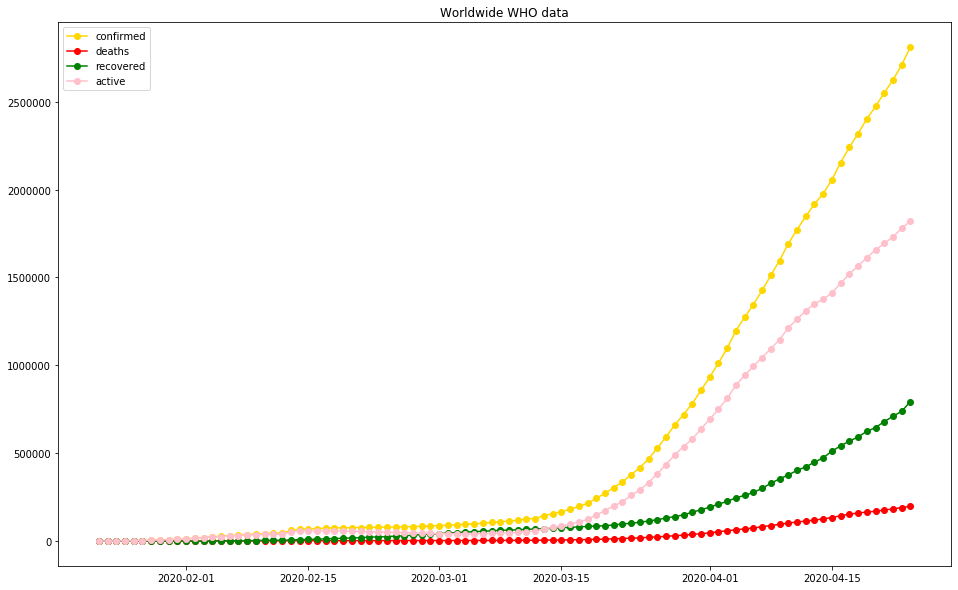

In [13]:
world_confirmed = []
world_deaths = []
world_recovered = []
world_active = []

for report in reports[:, 1]:
    world_stats = report.sum()
    world_confirmed.append(world_stats['Confirmed'])
    world_deaths.append(world_stats['Deaths'])
    world_recovered.append(world_stats['Recovered'])
    world_active.append(world_confirmed[-1] - world_deaths[-1] - world_recovered[-1])

fig, ax = plt.subplots(1, 1)
ax.set_title('Worldwide WHO data')
ax.plot(reports[:, 0], world_confirmed, 'o-', c='gold', label='confirmed')
ax.plot(reports[:, 0], world_deaths, 'o-', c='red', label='deaths')
ax.plot(reports[:, 0], world_recovered, 'o-', c='green', label='recovered')
ax.plot(reports[:, 0], world_active, 'o-', c='pink', label='active')
ax.legend()
plt.show()

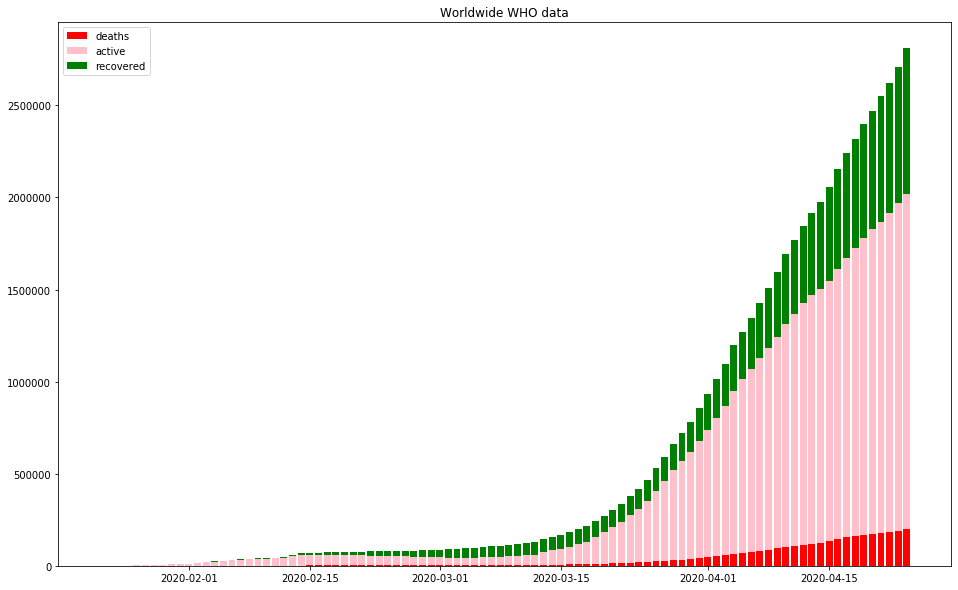

In [14]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Worldwide WHO data')
ax.bar(reports[:, 0], world_deaths, color='red', label='deaths')
ax.bar(reports[:, 0], world_active, color='pink', bottom=world_deaths, label='active')
active_and_deaths = np.array(world_active) + np.array(world_deaths)
ax.bar(reports[:, 0], world_recovered, color='green', bottom=active_and_deaths, label='recovered')
ax.legend()
plt.show()

# Plotting COVID data for certain regions

In [15]:
def plot_for_region(regions_list, plot_active=False, plot_confirmed=True):
    confirmed = []
    deaths = []
    recovered = []
    active = []

    for report in reports[:, 1]:
        region_aggregated_stats = report.groupby('Country/Region').sum()
        stats = region_aggregated_stats.reindex(regions_list).fillna(0).astype('int32').sum()
        confirmed.append(stats['Confirmed'])
        deaths.append(stats['Deaths'])
        recovered.append(stats['Recovered'])
        active.append(confirmed[-1] - deaths[-1] - recovered[-1])

    fig, ax = plt.subplots(1, 1)
    if len(regions_list) > 1:
        ax.set_title('WHO data for regions: ' + reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, regions_list, ""))
    else:
        ax.set_title('WHO data for the region ' + str(regions_list[0]))
                     
    if plot_confirmed:
        ax.plot(reports[:, 0], confirmed, 'o-', c='gold', label='confirmed')
    ax.plot(reports[:, 0], deaths, 'o-', c='red', label='deaths')
    ax.plot(reports[:, 0], recovered, 'o-', c='green', label='recovered')
    if plot_active:
        ax.plot(reports[:, 0], active, 'o-', c='pink', label='active')
    ax.legend()
    plt.show()

In [16]:
def barplot_for_region(regions_list):
    deaths = []
    recovered = []
    active = []

    for report in reports[:, 1]:
        region_aggregated_stats = report.groupby('Country/Region').sum()
        stats = region_aggregated_stats.reindex(regions_list).fillna(0).astype('int32').sum()
        deaths.append(stats['Deaths'])
        recovered.append(stats['Recovered'])
        active.append(stats['Confirmed'] - deaths[-1] - recovered[-1])

    fig, ax = plt.subplots(1, 1)
    if len(regions_list) > 1:
        ax.set_title('WHO data for regions: ' + reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, regions_list, ""))
    else:
        ax.set_title('WHO data for the region ' + str(regions_list[0]))

    ax.bar(reports[:, 0], deaths, color='red', label='deaths')
    ax.bar(reports[:, 0], active, color='pink', bottom=deaths, label='active')
    active_and_deaths = np.array(active) + np.array(deaths)
    ax.bar(reports[:, 0], recovered, color='green', bottom=active_and_deaths, label='recovered')

    ax.legend()
    plt.show()

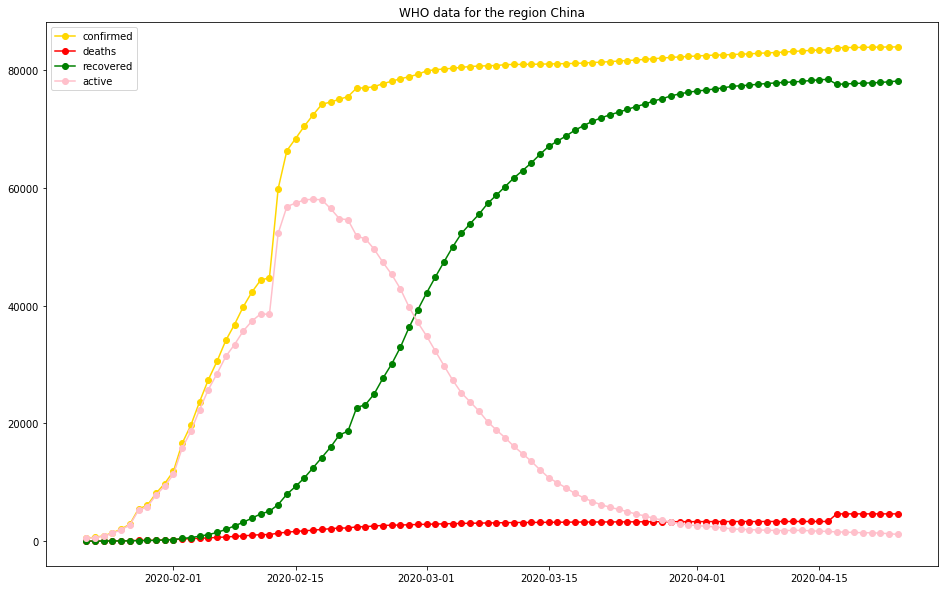

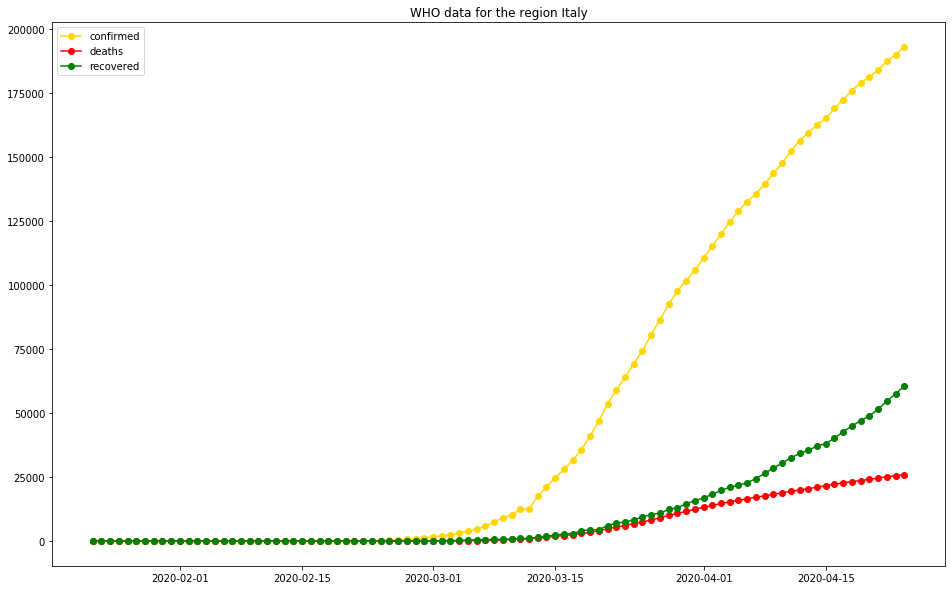

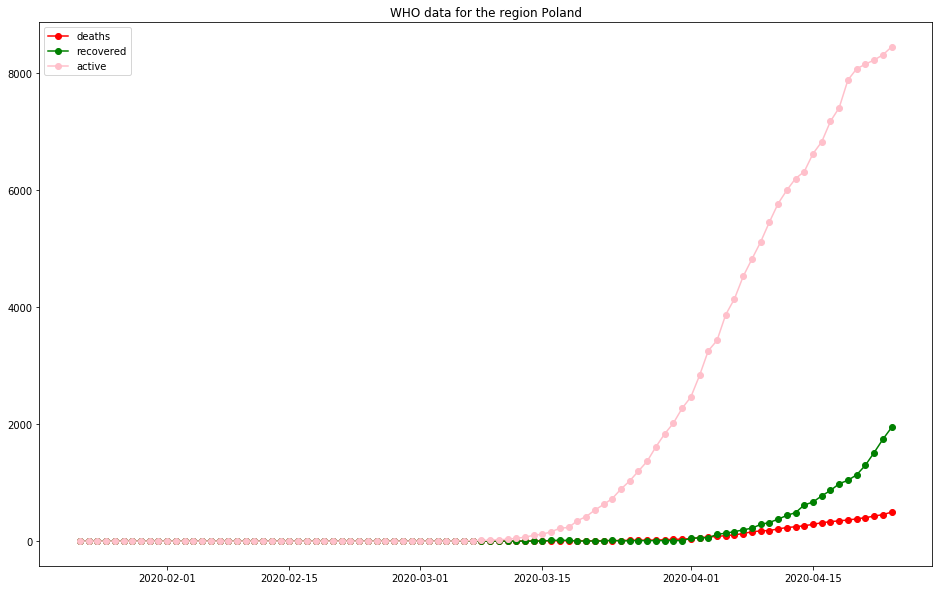

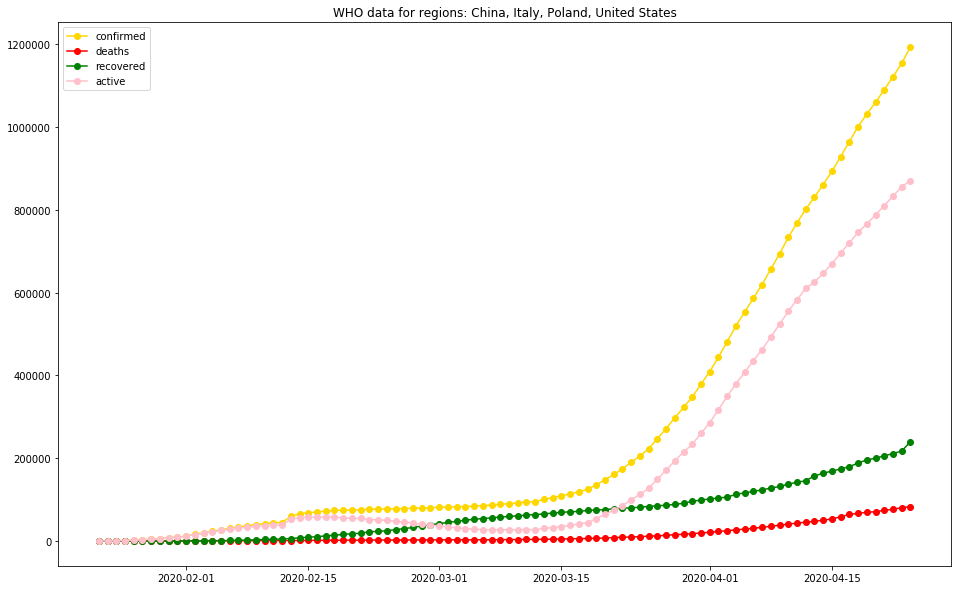

In [17]:
plot_for_region(['China'], plot_active=True)
plot_for_region(['Italy'])
plot_for_region(['Poland'], plot_active=True, plot_confirmed=False)
plot_for_region(['China', 'Italy', 'Poland', 'United States'], plot_active=True)

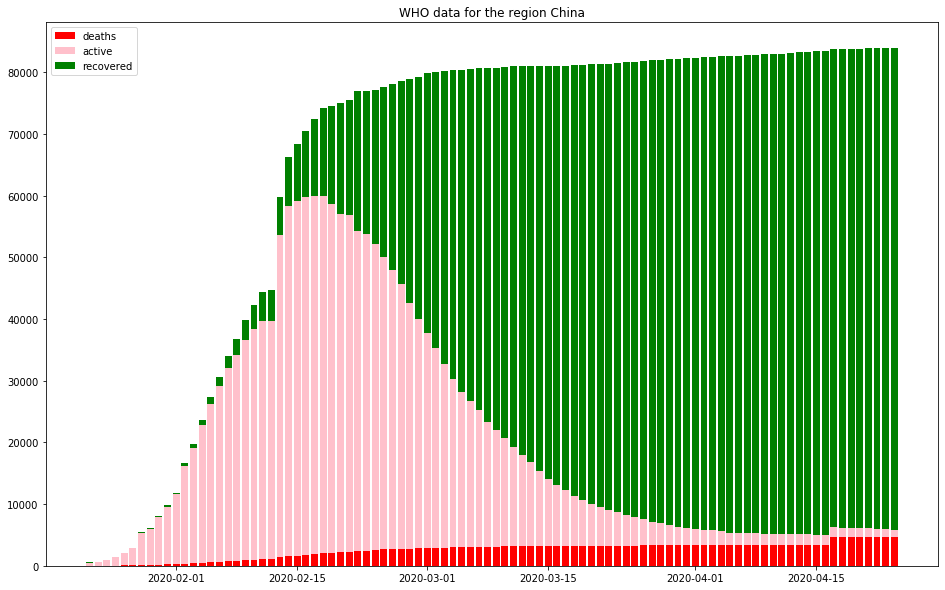

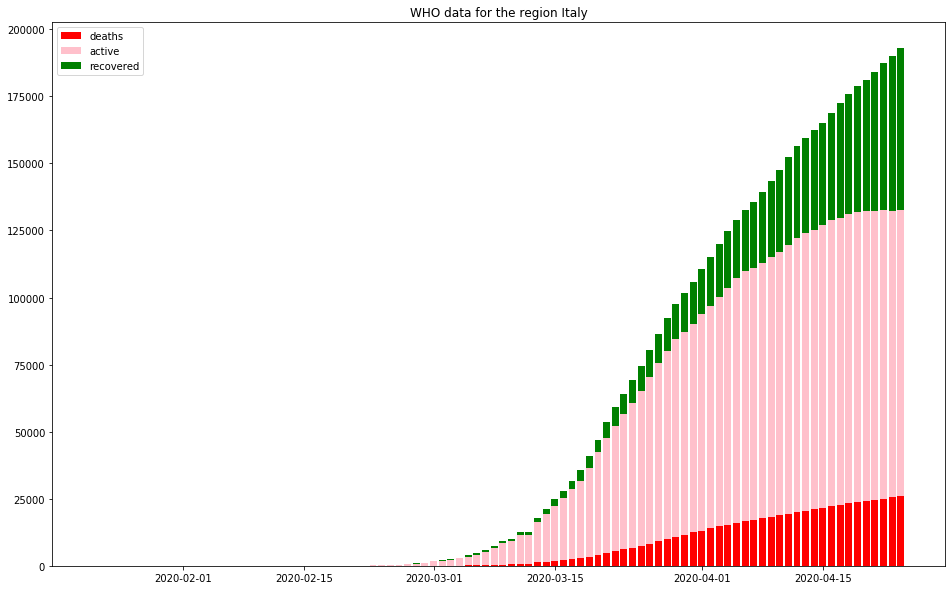

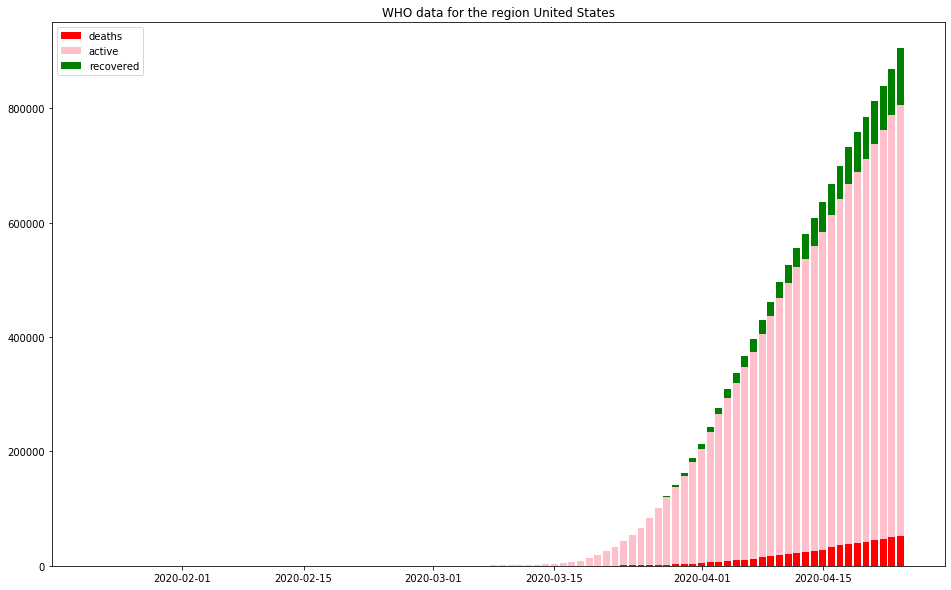

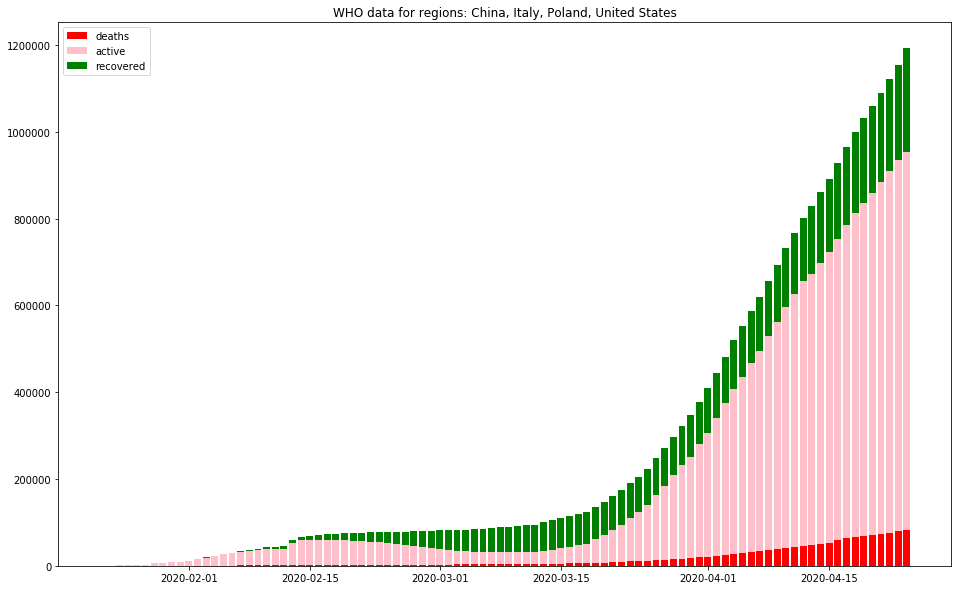

In [18]:
barplot_for_region(['China'])
barplot_for_region(['Italy'])
barplot_for_region(['United States'])
barplot_for_region(['China', 'Italy', 'Poland', 'United States'])

# Plotting latest WHO data on map 

### Getting geopandas world map dataframe

In [19]:
world_map_df = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_map_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Preparing world map dataframe (unify countries names)

In [20]:
countries_proper_names = {
    'W. Sahara': 'Western Sahara',
    'Dem. Rep. Congo': 'Congo',
    'Dominican Rep.': 'Dominican Republic',
    'Falkland Is.': 'Falkland Islands (Malvinas)',
    'Fr. S. Antarctic Lands': 'Antarctica',
    'Central African Rep.': 'Central African Republic',
    'Eq. Guinea': 'Equatorial Guinea',
    'Laos': 'Lao People\'s Democratic Republic',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'South Korea': 'Korea, Republic of',
    'Solomon Is.': 'Solomon Islands',
    'N. Cyprus': 'Cyprus',
    'Somaliland': 'Somalia',
    'Bosnia and Herz.': 'Bosnia and Herzegovina',
    'S. Sudan': 'South Sudan',
}

world_map_df.replace({'name': countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name for country in world_map_df['name']]
world_map_df['name'] = new_countries_names
world_map_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,"Tanzania, United Republic of",TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,Western Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Preparing latest report data (remove unrecognizable countries and aggregate)

In [21]:
latest_report = reports[-1, 1].copy()[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
latest_report = latest_report.loc[~latest_report['Country/Region'].isin(unrecognizable_countries), :]
latest_report = latest_report.groupby('Country/Region', as_index=False).sum()
latest_report.head()

,Country/Region,Confirmed,Deaths,Recovered
0,Afghanistan,1351,43,188
1,Albania,678,27,394
2,Algeria,3127,415,1408
3,Andorra,731,40,344
4,Angola,25,2,6


### Merging world map dataframe with latest WHO report dataframe

In [22]:
world_map_with_disease_data = world_map_df.join(latest_report.set_index("Country/Region"), on="name")
# Fill disease data for countries not included in report with 0
world_map_with_disease_data.fillna(0, inplace=True)

### Plotting disease data on world map

In [23]:
def plot_map(column_name, dataframe, title):
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '26'})
    dataframe.plot(column=column_name, cmap='Greys', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    plt.show()

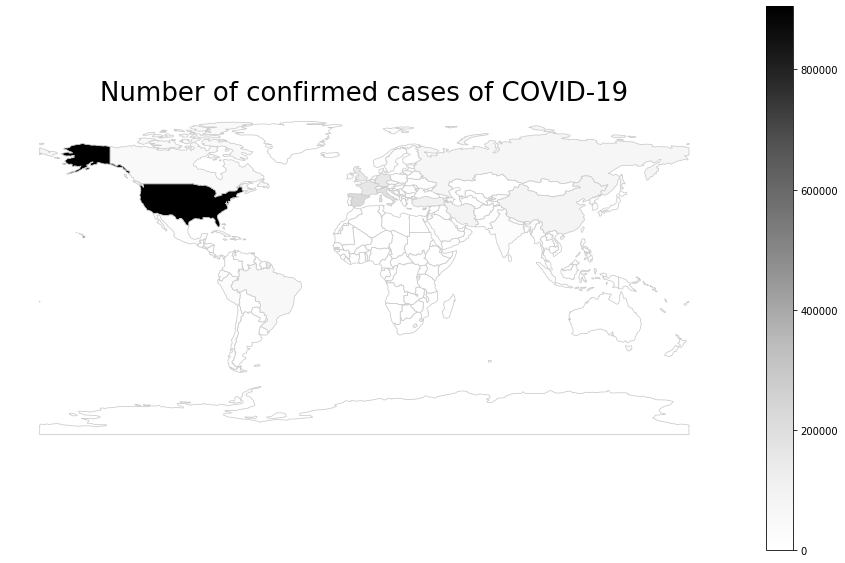

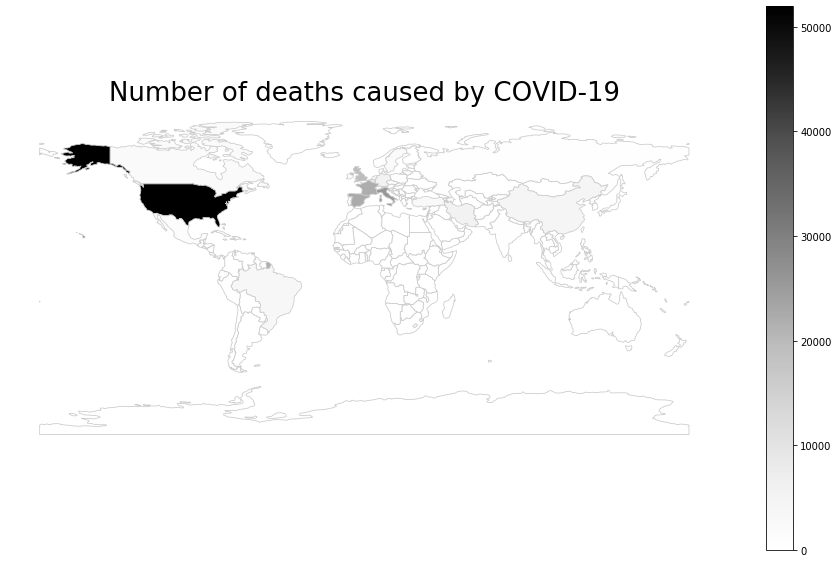

In [24]:
plot_map("Confirmed", world_map_with_disease_data, "Number of confirmed cases of COVID-19")   
plot_map("Deaths", world_map_with_disease_data, "Number of deaths caused by COVID-19")   

### Ploting disease data on Europe map (excluding Russia and French Guiana for clarity)

In [25]:
europe_stats_df = world_map_with_disease_data.loc[world_map_with_disease_data['continent'] == 'Europe', :]
europe_stats_df = europe_stats_df.loc[europe_stats_df['name'] != 'Russian Federation', :]
france_geometry_values = europe_stats_df.loc[europe_stats_df['name'] == 'France', 'geometry'].values
france_geometry_values[0] = france_geometry_values[0][1:]
europe_stats_df.loc[europe_stats_df['name'] == 'France', 'geometry'] = france_geometry_values

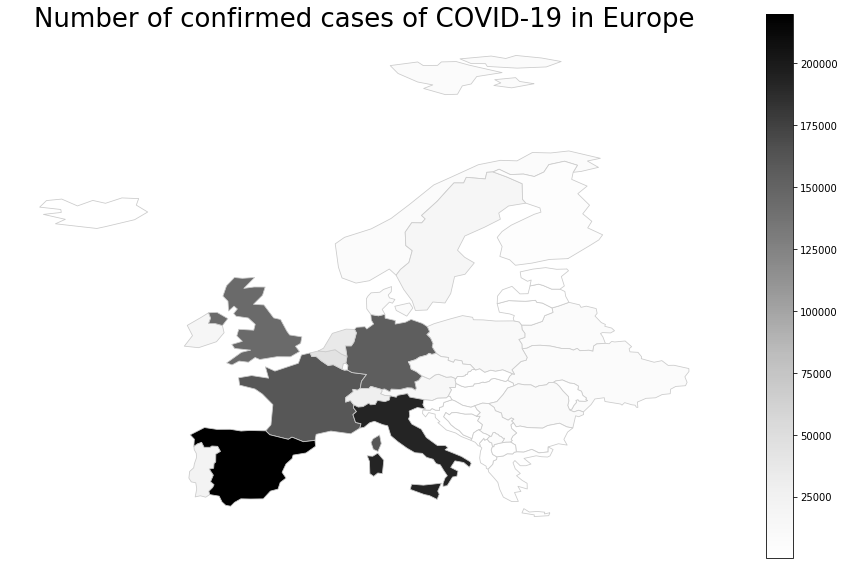

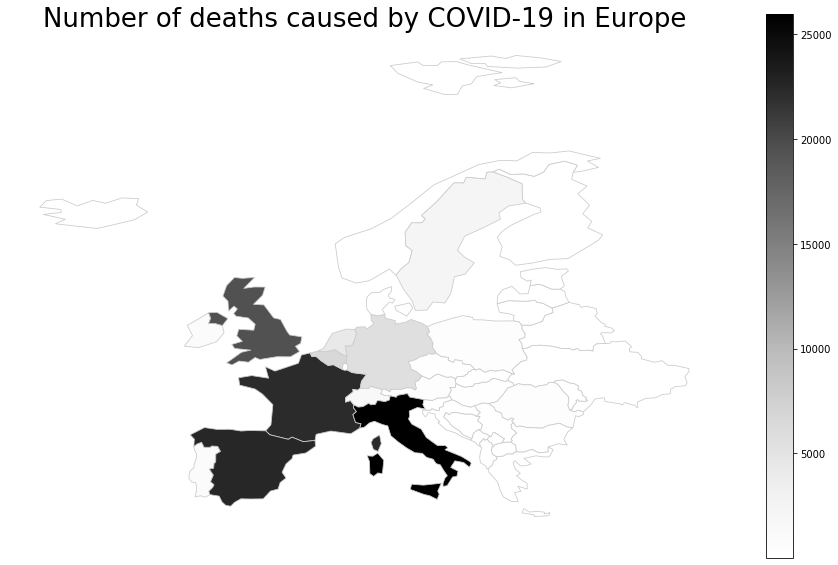

In [26]:
plot_map("Confirmed", europe_stats_df, "Number of confirmed cases of COVID-19 in Europe")
plot_map("Deaths", europe_stats_df, "Number of deaths caused by COVID-19 in Europe")   

### Getting population dataframe (data from https://worldpopulationreview.com/)

In [27]:
population_df = pd.read_csv("popultion.csv")[['name', 'pop2020']]
population_df["pop2020"] *= 1000
population_df = population_df.astype({'pop2020': 'int32'}, copy=False)
print('Population of Poland is:', population_df.loc[population_df['name'] == 'Poland', "pop2020"].values[0])
population_df.head()

Population of Poland is: 37846611


,name,pop2020
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


### Preparing population dataframe data (unify countries names)

In [28]:
countries_proper_names = {
    'DR Congo': 'Congo',
    'South Korea': 'Korea, Republic of',
    'Ivory Coast': 'Côte d\'Ivoire',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'Laos': 'Lao People\'s Democratic Republic',
    'Swaziland': 'Eswatini',
    'Macau': 'Macao',
    'Cape Verde': 'Cabo Verde',
    'United States Virgin Islands': 'United States',
}

population_df.replace({'name': countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name for country in population_df['name']]
population_df['name'] = new_countries_names
population_df = population_df.groupby('name', as_index=False).sum()
population_df.head()

,name,pop2020
0,Afghanistan,38928346
1,Albania,2877797
2,Algeria,43851044
3,American Samoa,55191
4,Andorra,77265


### Merging population dataframe with latest WHO report dataframe

In [29]:
latest_report_with_population = latest_report.join(population_df.set_index("name"), on='Country/Region')
# drop rows where pop2020 is NaN if there still are any
latest_report_with_population = latest_report_with_population.dropna(axis='index')
latest_report_with_population.head()

,Country/Region,Confirmed,Deaths,Recovered,pop2020
0,Afghanistan,1351,43,188,38928346
1,Albania,678,27,394,2877797
2,Algeria,3127,415,1408,43851044
3,Andorra,731,40,344,77265
4,Angola,25,2,6,32866271


### Calculating percentages of separate countries populations disease statistics

In [30]:
latest_report_with_population["Confirmed percentage"] = latest_report_with_population["Confirmed"] / latest_report_with_population["pop2020"]
latest_report_with_population["Deaths percentage"] = latest_report_with_population["Deaths"] / latest_report_with_population["pop2020"]
latest_report_with_population["Recovered percentage"] = latest_report_with_population["Recovered"] / latest_report_with_population["pop2020"]
latest_report_with_population.head()

,Country/Region,Confirmed,Deaths,Recovered,pop2020,Confirmed percentage,Deaths percentage,Recovered percentage
0,Afghanistan,1351,43,188,38928346,3.470479e-05,1.104594e-06,4.829386e-06
1,Albania,678,27,394,2877797,2.355969e-04,9.382177e-06,1.369103e-04
2,Algeria,3127,415,1408,43851044,7.130959e-05,9.463857e-06,3.210870e-05
3,Andorra,731,40,344,77265,9.460946e-03,5.176988e-04,4.452210e-03
4,Angola,25,2,6,32866271,7.606582e-07,6.085266e-08,1.825580e-07


### Merging world map dataframe with prepared dataframe containing percentage statistics

In [31]:
world_map_with_disease_percentage_data = world_map_df.join(latest_report_with_population.set_index("Country/Region"), on="name")
# Fill disease data for countries not included in report with 0
world_map_with_disease_percentage_data.fillna(0, inplace=True)

### Displaying most and least infected countries

In [32]:
max_infected = latest_report_with_population.sort_values(by=['Confirmed percentage'], ascending=False).iloc[:10, :]
print('Countries with maximal percentage of population infected:\n')
for i in range(10):
    print(max_infected.iloc[i, :]['Country/Region'], '-', max_infected.iloc[i, :]['Confirmed percentage'])

Countries with maximal percentage of population infected:

San Marino - 0.015118917803778257
Holy See (Vatican City State) - 0.011235955056179775
Andorra - 0.00946094609460946
Luxembourg - 0.005902763355900687
Iceland - 0.005242598382970493
Spain - 0.004700353833355812
Belgium - 0.003821780915565588
Ireland - 0.003682622130647217
Switzerland - 0.0033134896012789465
Italy - 0.003191997542383189


In [33]:
min_infected = latest_report_with_population.sort_values(by=['Confirmed percentage']).iloc[:10, :]
print('Countries with minimal percentage of population infected (among ones with infected ppl):\n')
for i in range(10):
    print(min_infected.iloc[i, :]['Country/Region'], '-', min_infected.iloc[i, :]['Confirmed percentage'])

Countries with minimal percentage of population infected (among ones with infected ppl):

Yemen - 3.352783500979214e-08
South Sudan - 4.4667883122017025e-07
Angola - 7.606582444354579e-07
Papua New Guinea - 8.941520666536717e-07
Burundi - 9.250861843928878e-07
Ethiopia - 1.0177135390033234e-06
Mauritania - 1.5054870702318322e-06
Uganda - 1.6396665687749289e-06
Nicaragua - 1.660489143872931e-06
Nepal - 1.6817216216683722e-06


### Plotting percentage disease data on world map

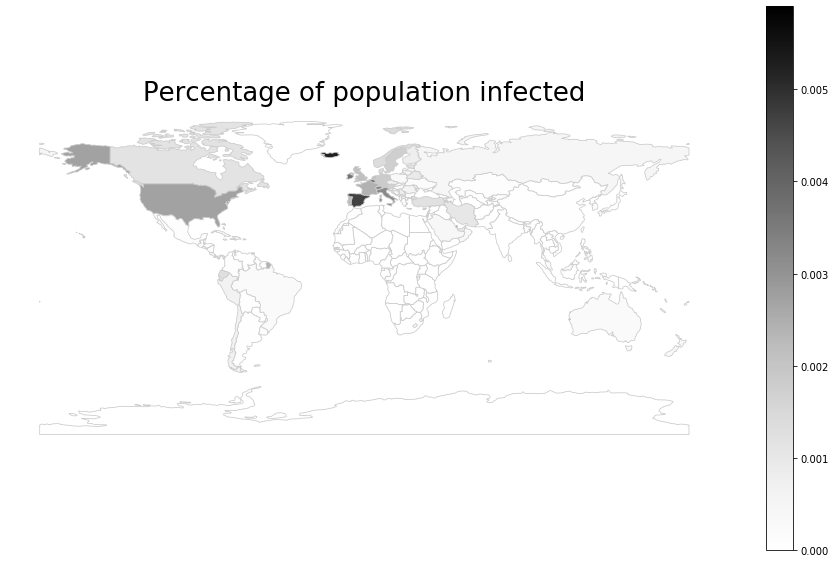

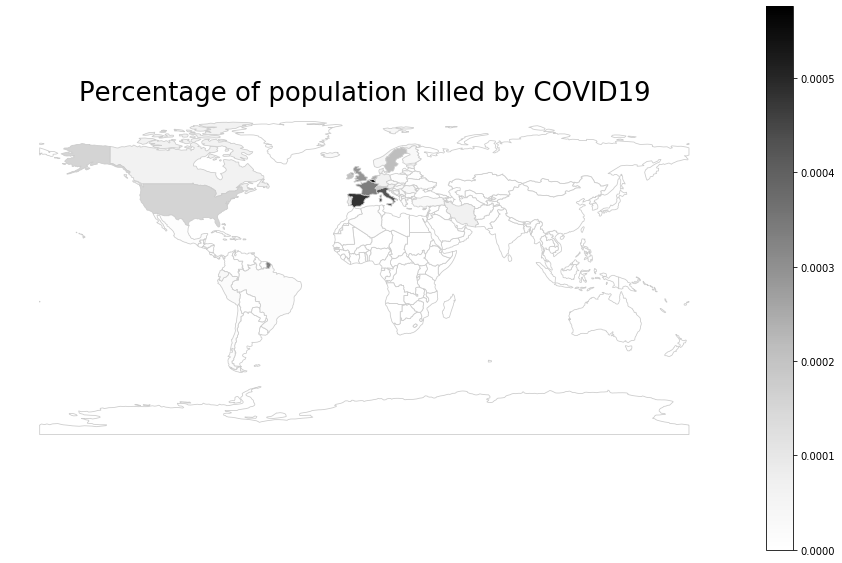

In [34]:
plot_map("Confirmed percentage", world_map_with_disease_percentage_data, "Percentage of population infected")
plot_map("Deaths percentage", world_map_with_disease_percentage_data, "Percentage of population killed by COVID19")

### Displaying most and least infected European countries 

In [35]:
europe_map_with_disease_percentage_data = world_map_with_disease_percentage_data.loc[world_map_with_disease_percentage_data['continent'] == 'Europe', :].copy()
france_geometry_values = europe_map_with_disease_percentage_data.loc[europe_map_with_disease_percentage_data['name'] == 'France', 'geometry'].values
france_geometry_values[0] = france_geometry_values[0][1:]
europe_map_with_disease_percentage_data.loc[europe_map_with_disease_percentage_data['name'] == 'France', 'geometry'] = france_geometry_values

In [36]:
max_infected_europe = europe_map_with_disease_percentage_data.sort_values(by=['Confirmed percentage'], ascending=False).iloc[:10, :]
print('European countries with maximal percentage of population infected:\n')
for i in range(10):
    print(max_infected_europe.iloc[i, :]['name'], '-', max_infected_europe.iloc[i, :]['Confirmed percentage'])

European countries with maximal percentage of population infected:

Luxembourg - 0.005902763355900687
Iceland - 0.005242598382970493
Spain - 0.004700353833355812
Belgium - 0.003821780915565588
Ireland - 0.003682622130647217
Switzerland - 0.0033134896012789465
Italy - 0.003191997542383189
France - 0.002425483100303352
Portugal - 0.002235721348917577
United Kingdom - 0.0021306304180989514


In [37]:
min_infected_europe = europe_map_with_disease_percentage_data.sort_values(by=['Confirmed percentage']).iloc[:10, :]
print('European countries with minimal percentage of population infected:\n')
for i in range(10):
    print(min_infected_europe.iloc[i, :]['name'], '-', min_infected_europe.iloc[i, :]['Confirmed percentage'])

European countries with minimal percentage of population infected:

Bulgaria - 0.00017759369182601288
Ukraine - 0.00018578323996001076
Albania - 0.00023559688192044122
Greece - 0.00023889351431931563
Slovakia - 0.0002491005820528159
Hungary - 0.0002528893618875753
Poland - 0.0002877932716353388
Latvia - 0.0004156509549898791
Bosnia and Herzegovina - 0.00043312355847731923
Russian Federation - 0.00047022477802398724


### Ploting percentage disease data on Europe map (excluding Russia and French Guiana for clarity)

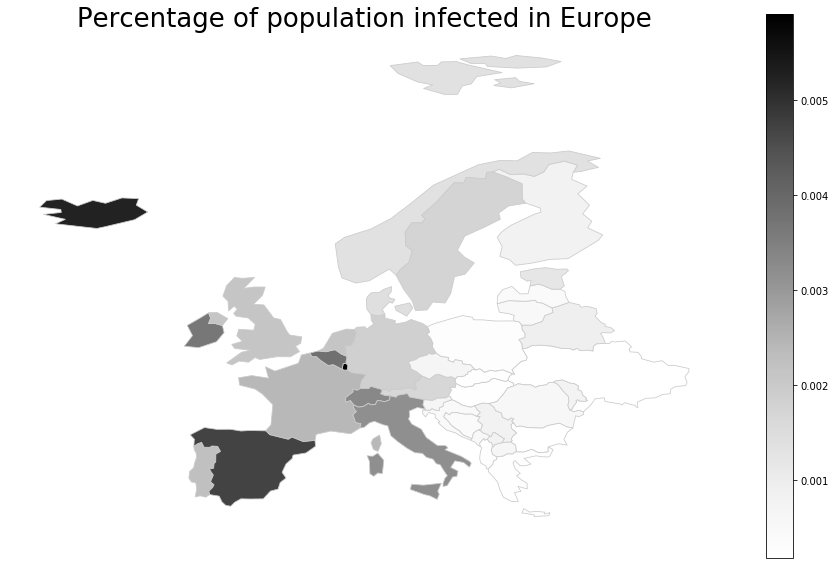

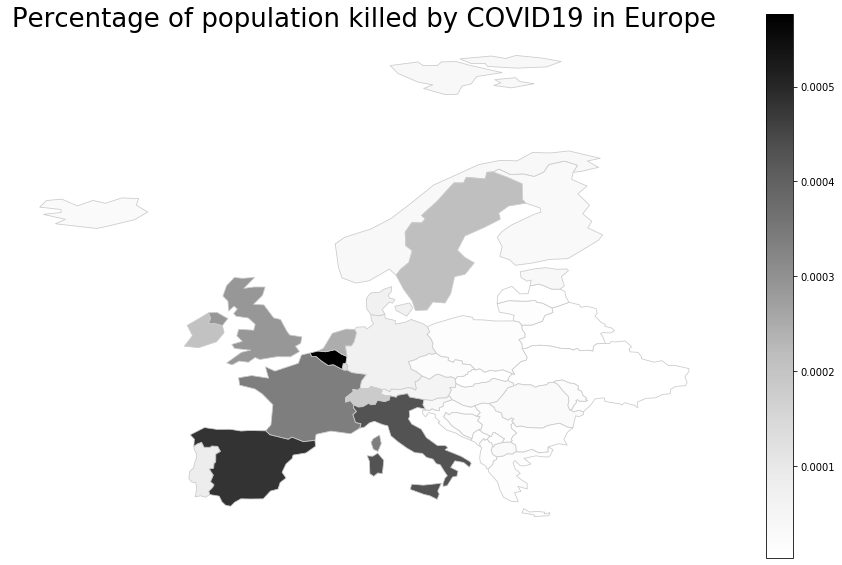

In [38]:
europe_map_with_disease_percentage_data = europe_map_with_disease_percentage_data.loc[europe_map_with_disease_percentage_data['name'] != 'Russian Federation', :]
plot_map("Confirmed percentage", europe_map_with_disease_percentage_data, "Percentage of population infected in Europe")
plot_map("Deaths percentage", europe_map_with_disease_percentage_data, "Percentage of population killed by COVID19 in Europe")